In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [5]:
import pickle as pkl
from typing import List

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange

from mtt.models import load_model
from mtt.data import vector_to_image, stack_images, simulation_window, VectorData
from mtt.peaks import find_peaks
from mtt.utils import compute_ospa

rng = np.random.default_rng()
sns.set_theme("paper", "ticks", font_scale=1.5)  # type: ignore

In [6]:
scale = 1

with open(f"../data/test/{scale}km/simulations.pkl", "rb") as f:
    dataset_vectors: List[List[VectorData]] = pkl.load(f)

dataset_idx = 42
images = map(vector_to_image,dataset_vectors[dataset_idx])
stacked = simulation_window(stack_images(images))


In [7]:
cardinality = []
for simulation in dataset_vectors:
    cardinality.append([])
    for step in simulation:
        cardinality[-1].append(len(step.target_positions))

In [27]:
simulator = dataset_vectors[0][0].simulator
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]
n_detections = (
    simulator.n_sensors * np.pi * simulator.sensors[0].range_max ** 2 / 1000**2
)

In [33]:
# Make CNN Predictions
model, name = load_model("wandb://damowerko/mtt/4uc51x21")
model = model.cuda()

x = torch.stack([d.sensor_images for d in stacked], dim=0)
with torch.no_grad():
    output_images = model(x.cuda())
    pred_img = output_images.cpu().numpy()

n = pred_img.shape[0]
filt_idx = -1

width = simulator.simulation_width
window = simulator.window_width
extent = [-window / 2, window / 2, -window / 2, window / 2]

predictions_cnn = []
for i in trange(n):
    predictions_cnn.append(find_peaks(pred_img[i][filt_idx], width=window)[0])

wandb:   1 of 1 files downloaded.  
/home/damow/.pyenv/versions/3.9.9/envs/mtt/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.4, which is newer than your current Lightning version: v1.9.3
  rank_zero_warn(
100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


In [35]:
output_images.clamp_min(0).sum(axis=(-1,-2)).mean().item()

8.84735107421875

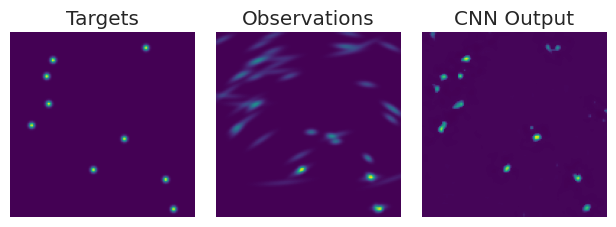

In [36]:
idx = dataset_idx
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[0].set_title("Targets")
axs[1].imshow(stacked[idx][0][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[1].set_title("Observations")
axs[2].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="viridis")
axs[2].set_title("CNN Output")
for ax in axs:
    ax.axis("off")
plt.savefig("../figures/images.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [58]:
np.clip(pred_img, a_min=0).sum(axis=(-1,-2))

array([[ 9.680591 ],
       [ 7.96148  ],
       [ 9.550577 ],
       [ 9.331343 ],
       [ 9.305366 ],
       [10.209429 ],
       [ 7.1618495],
       [ 9.058615 ],
       [ 7.934809 ],
       [ 5.0094924],
       [ 8.630594 ],
       [ 8.076193 ],
       [ 9.553007 ],
       [ 9.250156 ],
       [ 6.955643 ],
       [ 7.1356397],
       [ 8.228189 ],
       [ 5.739037 ],
       [ 8.000737 ],
       [ 8.055225 ],
       [ 8.054689 ],
       [ 8.651829 ],
       [ 8.862736 ],
       [10.162266 ],
       [10.173996 ],
       [ 9.470242 ],
       [ 8.081625 ],
       [ 8.719002 ],
       [ 7.945673 ],
       [ 8.468159 ],
       [ 5.972932 ],
       [ 5.0705914],
       [ 4.9390864],
       [ 5.531577 ],
       [ 3.8220048],
       [ 3.8820062],
       [ 6.002384 ],
       [ 4.1902766],
       [ 4.403206 ],
       [ 4.560333 ],
       [ 5.954243 ],
       [ 6.3066587],
       [ 9.454651 ],
       [ 7.8749456],
       [ 7.808901 ],
       [ 6.962078 ],
       [ 9.08276  ],
       [10.31

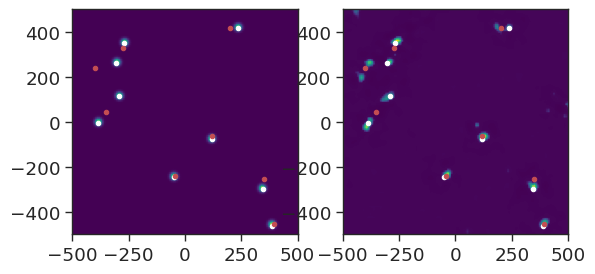

In [37]:
idx = dataset_idx
fig, axs = plt.subplots(1, 2)
target_pos = stacked[idx][2][filt_idx]["target_positions"]
mu, *_ = find_peaks(pred_img[idx][filt_idx], width=window)

axs[0].imshow(stacked[idx][1][filt_idx].cpu(), extent=extent, origin="lower", cmap="viridis")
axs[1].imshow(pred_img[idx][filt_idx], extent=extent, origin="lower", cmap="viridis")
for ax in axs:
    ax.scatter(*target_pos.T, c="w", s=10)
    ax.scatter(*mu.T, c="r", s=10)
    ax.set_xlim(-window / 2, window / 2)
    ax.set_ylim(-window / 2, window / 2)
plt.show()


In [38]:
mean_energy = np.mean([pos_img[1].cpu().sum(dim=[-1,-2]) for _, pos_img, _ in stacked])
mean_cardinality = np.mean([len(info["target_positions"]) for _,_,infos in stacked for info in infos])
mean_energy, mean_cardinality

(9.732694, 10.229)

In [40]:
card_true = np.array([len(d[2][filt_idx]["target_positions"]) for d in stacked])
card_cnn = np.array([len(p) for p in predictions_cnn])

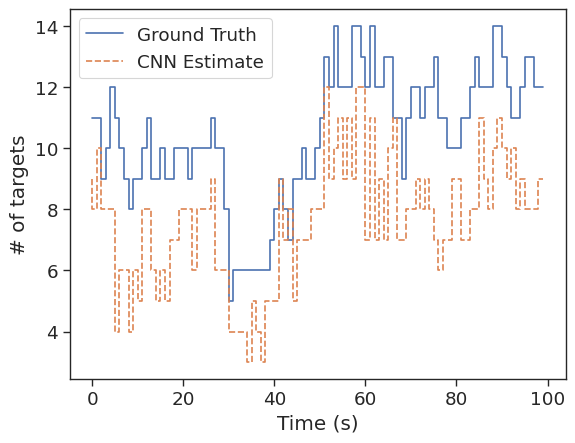

In [41]:
# plot cardinality
plt.step(np.arange(n), card_true, label="Ground Truth")
plt.step(np.arange(n), card_cnn, label="CNN Estimate", linestyle="dashed")
plt.xlabel("Time (s)")
plt.ylabel("# of targets")
plt.legend()
plt.savefig("../figures/cardinality.pdf")

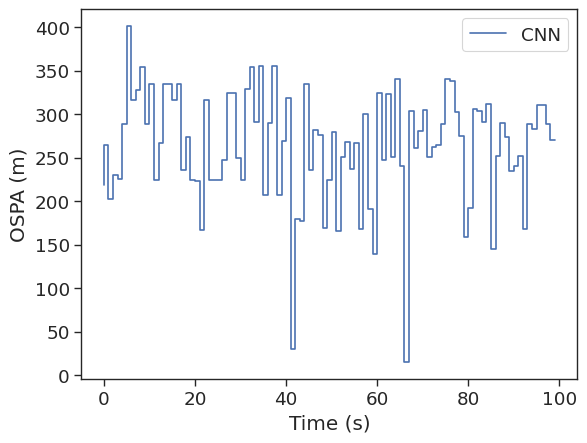

In [50]:
ospa_cnn = []
for idx in range(n):
    sensor_img, target_img, info = stacked[idx]
    target_positions = info[-1]["target_positions"]
    ospa_cnn += [compute_ospa(target_positions, predictions_cnn[idx], 500)]



plt.figure()
plt.step(np.arange(n), ospa_cnn, label="CNN")
plt.ylabel("OSPA (m)")
plt.xlabel("Time (s)")
plt.legend()
plt.savefig("../figures/ospa.pdf")


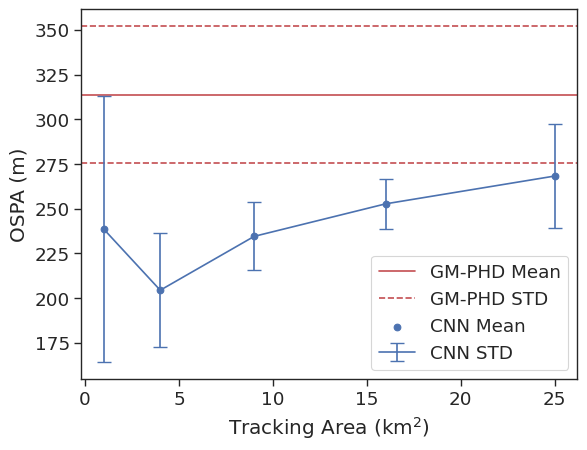

In [13]:
# plot CNN performance generalization
df = pd.DataFrame(
    dict(
        width=[1, 2, 3, 4, 5],
        cnn_mean=[238.45, 204.34, 234.48, 252.68, 268.24],
        cnn_std=[74.40, 31.97, 19.04, 14.05, 29.04],
    )
)
phd_std = 76.58
phd_mean = 313.78

plt.figure()
plt.axhline(phd_mean, color="r", label="GM-PHD Mean")
plt.axhline(phd_mean + phd_std / 2, color="r", linestyle="--", label="GM-PHD STD")
plt.axhline(phd_mean - phd_std / 2, color="r", linestyle="--")
plt.scatter(df.width**2, df.cnn_mean, label="CNN Mean")
plt.errorbar(df.width**2, df.cnn_mean, yerr=df.cnn_std, capsize=5, label="CNN STD")
plt.legend()
plt.xlabel("Tracking Area (km$^2$)")
plt.ylabel("OSPA (m)")
plt.savefig("../figures/transfer.pdf")